Projeto de Disciplina – Wikipédia: Lista de jogos licenciados do Nintendo Entertainment System
---

Universidade Federal de São Carlos

Curso: Bacharelado em Ciência da Computação de Sorocaba

Disciplina: Novas Tecnologias de Bancos de Dados

Professora: Profa. Dra. Sahudy Montenegro González

---

Grupo 10

Integrantes:
- Anne Mari Suenaga Sakai (822304)
- Felipe Pregnolatto Melo (822825)

---

Resumo:

Este projeto constrói um Data Lakehouse sobre os jogos licenciados do Nintendo Entertainment System (NES), utilizando dados extraídos da Wikipédia por meio de sua API e processados com BeautifulSoup. Os dados passam pelas camadas Bronze, Prata e Ouro até se consolidarem em tabelas estruturadas para análise. O sistema final adota um esquema estrela composto por uma tabela fato e três dimensões (desenvolvedora, publicadora e data), incluindo uma referência temporal para cada região de lançamento (Japão, América do Norte e região PAL). O objetivo é oferecer uma base organizada para consultas históricas, análises comparativas e estudos sobre padrões de parceria, distribuição de lançamentos e comportamento do mercado da época.


![ETL_GRUPO10 (1).jpg](./ETL_GRUPO10.jpg "ETL_GRUPO10.jpg")

# 1 Camada Bronze
Na camada Bronze, realizamos a ingestão dos dados brutos diretamente da página oficial da Wikipédia contendo a lista completa de jogos licenciados de Nintendo Entertainment System (NES).

## 1.1 Extração do HTML pela API da Wikipédia
Como a API da Wikipédia não fornece os dados da tabela em formato estruturado, utilizamos a API apenas para baixar o HTML bruto, e então empregamos o BeautifulSoup para extrair manualmente as informações da tabela.

Utilizamos BeautifulSoup para navegar e interpretar o HTML, identificando a tabela de interesse (id="softwarelist").

In [0]:
# %pip install lxml

In [0]:
import requests
import pandas as pd
from bs4 import BeautifulSoup, NavigableString, Tag

API_URL = "https://en.wikipedia.org/w/api.php"

params = {
    "action": "parse",
    "page": "List_of_Nintendo_Entertainment_System_games",
    "prop": "text",
    "section": 1,  # Licensed games
    "format": "json"
}

headers = {
    "User-Agent": "Databricks-NES-ETL/1.0 (anne.projeto@example.com)"
}

# 1) BAIXAR HTML DA SEÇÃO
response = requests.get(API_URL, params=params, headers=headers)
response.raise_for_status()
html = response.json()["parse"]["text"]["*"]

soup = BeautifulSoup(html, "html.parser")

table = soup.find("table", {"id": "softwarelist"})

## 1.2 Parsing manual do HTML

Após obter o HTML bruto via MediaWiki API, cada linha da tabela (`<tr>`) foi processada individualmente para extrair os dados com precisão. Essa etapa é necessária porque a estrutura da Wikipédia é altamente irregular, contendo misturas de texto, links, anotações, múltiplas entradas em uma mesma célula, além de formatação HTML inconsistente.

Os principais pontos que exigiram parsing manual foram:

### Título
Alguns jogos apresentam nomes alternativos ou formatações variadas, mas o título principal aparece sempre dentro da primeira tag `<i>`.  
Por isso, extraímos apenas a primeira ocorrência de `<i>`, que corresponde ao nome oficial do jogo.

### Publisher
A coluna de publicadoras é a mais heterogênea da tabela, podendo assumir diferentes formatos:

- texto simples;
- nomes dentro de links (`<a>`), com ou sem regiões associadas;
- múltiplas publicadoras separadas por `<br>`;
- regiões indicadas por `<sup>`;
- combinações entre texto puro e elementos `<a>`.

Essas variações impossibilitam extração automática padrão.

Para lidar com essa complexidade, foram aplicadas regras explícitas ao percorrer cada elemento da célula:

- identificação precisa de cada tipo de nó HTML (`<a>`, `<sup>`, `<br>`, `NavigableString`);
- associação correta entre publicadora e a região indicada no `<sup>` correspondente;
- geração de múltiplas linhas quando há mais de uma publicadora, garantindo que cada associação publicadora–região seja preservada.

Esse método garante que toda a multiplicidade de informações seja mantida de forma fiel à fonte original.

### Resultado do parsing
Após o processamento manual, obtém-se um dataset base contendo:

- **Titulo**
- **Desenvolvedora**
- **Publicadora**
- **Release_JP**
- **Release_NA**
- **Release_PAL**


In [0]:
# -----------------------
# 2) PROCESSAR MANUALMENTE CADA TR
# -----------------------
rows_processed = []

for tr in table.find_all("tr"):
    tds = tr.find_all("td")

    if len(tds) < 7:
        continue  # pular header ou linhas inválidas

    # ----------  TÍTULO  ----------
    i_tag = tds[0].find("i")
    title = i_tag.get_text(strip=True) if i_tag else tds[0].get_text(strip=True)


    # ----------  DEVELOPER ----------
    developer = tds[1].get_text(" ", strip=True)

    # ----------  PUBLISHER ----------
    publisher_td = tds[2]
    publisher_entries = []  # lista de (nome, região)
    current_name = None
    current_region = None

    for elem in publisher_td.children:

        # Caso 1: nome sem link (texto puro)
        if isinstance(elem, NavigableString):
            name = elem.strip()

            # ignorar separadores
            if name and name not in ["", ","]:
                current_name = name

        # Caso 2: nome com link
        elif isinstance(elem, Tag) and elem.name == "a":
            current_name = elem.get_text(strip=True)

        # Caso 3: região <sup>
        elif isinstance(elem, Tag) and elem.name == "sup":
            current_region = elem.get_text(strip=True)

            # Se temos nome + região --> registrar
            if current_name:
                publisher_entries.append((current_name, current_region))
                current_name = None
                current_region = None

        # Caso 4: quebra de linha
        elif isinstance(elem, Tag) and elem.name == "br":
            continue

    # Caso especial: nome sem <sup>
    if current_name and not publisher_entries:
        publisher_entries.append((current_name, None))

    # ----------  RELEASES ----------
    release_jp = tds[4].get_text(strip=True) or "Unreleased"
    release_na = tds[5].get_text(strip=True) or "Unreleased"
    release_pal = tds[6].get_text(strip=True) or "Unreleased"

    release_map = {
        "JP": release_jp,
        "NA": release_na,
        "PAL": release_pal
    }

    # ----------  CRIAR LINHAS ----------
    for pub_name, region in publisher_entries:

        row = {
            "Titulo": title,
            "Desenvolvedora": developer,
            "Publicadora": pub_name,
            "Release_JP": "Unreleased",
            "Release_NA": "Unreleased",
            "Release_PAL": "Unreleased",
        }

        # Se não há região (nenhum <sup>)
        if region is None:
            row["Release_JP"] = release_jp
            row["Release_NA"] = release_na
            row["Release_PAL"] = release_pal

        else:
            # Pode ser mais de uma região, tipo "NA/PAL"
            for r in region.split("/"):
                if r in release_map:
                    row[f"Release_{r}"] = release_map[r]

        rows_processed.append(row)


In [0]:
df = pd.DataFrame(rows_processed)

display(df)
print(f"Total de jogos licenciados: {len(df)}")

Titulo,Desenvolvedora,Publicadora,Release_JP,Release_NA,Release_PAL
89 Dennō Kyūsei Uranai,Micronics,Jingukan Polaris,"December 10, 1988",Unreleased,Unreleased
2nd Super Robot Wars,Winkysoft,Banpresto,"December 29, 1991[6]",Unreleased,Unreleased
The 3-D Battles of WorldRunner,Square,Acclaim Entertainment,Unreleased[a],September 1987,Unreleased
4 Nin Uchi Mahjong,Hudson Soft,Nintendo,"November 2, 1984",Unreleased,Unreleased
8 Eyes,Thinking Rabbit,SETA,"September 27, 1988",Unreleased,Unreleased
8 Eyes,Thinking Rabbit,Taxan,Unreleased,January 1990,Unreleased
10-Yard Fight,Tose,Irem,"August 30, 1985",Unreleased,Unreleased
10-Yard Fight,Tose,Nintendo,Unreleased,"October 18, 1985","December 6, 1986"
720°,Beam Software,Mindscape,Unreleased,December 1989,Unreleased
1942,Micronics,Capcom,"December 11, 1985",November 1986,Unreleased


Total de jogos licenciados: 1590


--
# 2 Camada Prata

Esta camada é responsável por padronizar os dados. Como a fonte de dados já teve a maioria dos dados padronizados, a única transformação necessária foi a das datas.
As datas podiam vir em três formas:
- Mês(por extenso) dia, Ano
- Mês(por extenso), Ano
- Ano

Então o código python cria novas colunas para adicionar:
- O ano
- O número de mês
- O dia
- O nome do mês em português
- A data completa em string em português

Em colunas separadas, sendo essas 5 colunas para cada uma das 3 regiões.
As regiões que estavam unreleased ficaram com o campo de ano nulo e o valor do mês e dia como -1.

In [0]:
if isinstance(df, pd.DataFrame):
    df = spark.createDataFrame(df)

from pyspark.sql.functions import (
    regexp_replace, regexp_extract, trim, when, lit, col
)

def padronizar_data(df, col_name):

    # 1. LIMPEZA DA COLUNA
    df = df.withColumn(col_name, regexp_replace(col_name, r"\[.*?\]", ""))   # remove [] vindo da extração dos elementos da Wikipédia

    # 2. EXTRAÇÃO DE PARTES DA DATA
    mes_en = regexp_extract(col(col_name), r"([A-Za-z]+)", 1)
    ano = regexp_extract(col(col_name), r"(\d{4})$", 1)
    dia = regexp_extract(col(col_name), r"[A-Za-z]+\s+(\d{1,2}),?\s+\d{4}",1)

    # 3. MÊS NUMÉRICO
    mes_num = (
        when(mes_en == "January", 1)
        .when(mes_en == "February", 2)
        .when(mes_en == "March", 3)
        .when(mes_en == "April", 4)
        .when(mes_en == "May", 5)
        .when(mes_en == "June", 6)
        .when(mes_en == "July", 7)
        .when(mes_en == "August", 8)
        .when(mes_en == "September", 9)
        .when(mes_en == "October", 10)
        .when(mes_en == "November", 11)
        .when(mes_en == "December", 12)
        .otherwise(None)
    )

    # 4. TRADUÇÃO EN para PT
    mes = (
        when(mes_en == "January", "Janeiro")
        .when(mes_en == "February", "Fevereiro")
        .when(mes_en == "March", "Março")
        .when(mes_en == "April", "Abril")
        .when(mes_en == "May", "Maio")
        .when(mes_en == "June", "Junho")
        .when(mes_en == "July", "Julho")
        .when(mes_en == "August", "Agosto")
        .when(mes_en == "September", "Setembro")
        .when(mes_en == "October", "Outubro")
        .when(mes_en == "November", "Novembro")
        .when(mes_en == "December", "Dezembro")
        .otherwise(None)
    )

    # 5. -1 QUANDO ESTIVER VAZIO
    dia_final = when(dia == "", lit(-1)).otherwise(dia)

    # 6. CRIAÇÃO DAS NOVAS COLUNAS
    df = df.withColumn(f"{col_name}_ano", ano)
    df = df.withColumn(f"{col_name}_mes_num", mes_num.cast("int"))
    df = df.withColumn(f"{col_name}_dia", dia_final)
    df = df.withColumn(f"{col_name}_mes", mes)

    return df


for region in ["Release_JP", "Release_NA", "Release_PAL"]:
    df = padronizar_data(df, region)

display(df)

Titulo,Desenvolvedora,Publicadora,Release_JP,Release_NA,Release_PAL,Release_JP_ano,Release_JP_mes_num,Release_JP_dia,Release_JP_mes,Release_NA_ano,Release_NA_mes_num,Release_NA_dia,Release_NA_mes,Release_PAL_ano,Release_PAL_mes_num,Release_PAL_dia,Release_PAL_mes
89 Dennō Kyūsei Uranai,Micronics,Jingukan Polaris,"December 10, 1988",Unreleased,Unreleased,1988,12,10,Dezembro,,null,-1,null,,null,-1,null
2nd Super Robot Wars,Winkysoft,Banpresto,"December 29, 1991",Unreleased,Unreleased,1991,12,29,Dezembro,,null,-1,null,,null,-1,null
The 3-D Battles of WorldRunner,Square,Acclaim Entertainment,Unreleased,September 1987,Unreleased,,null,-1,null,1987,9,-1,Setembro,,null,-1,null
4 Nin Uchi Mahjong,Hudson Soft,Nintendo,"November 2, 1984",Unreleased,Unreleased,1984,11,2,Novembro,,null,-1,null,,null,-1,null
8 Eyes,Thinking Rabbit,SETA,"September 27, 1988",Unreleased,Unreleased,1988,9,27,Setembro,,null,-1,null,,null,-1,null
8 Eyes,Thinking Rabbit,Taxan,Unreleased,January 1990,Unreleased,,null,-1,null,1990,1,-1,Janeiro,,null,-1,null
10-Yard Fight,Tose,Irem,"August 30, 1985",Unreleased,Unreleased,1985,8,30,Agosto,,null,-1,null,,null,-1,null
10-Yard Fight,Tose,Nintendo,Unreleased,"October 18, 1985","December 6, 1986",,null,-1,null,1985,10,18,Outubro,1986,12,6,Dezembro
720°,Beam Software,Mindscape,Unreleased,December 1989,Unreleased,,null,-1,null,1989,12,-1,Dezembro,,null,-1,null
1942,Micronics,Capcom,"December 11, 1985",November 1986,Unreleased,1985,12,11,Dezembro,1986,11,-1,Novembro,,null,-1,null


# 3 Camada Ouro

## DimData


Aqui, pegamos as datas de cada região e fazemos uma union, capturando todas as datas unicas que existem.
Também criamos a linha especial para as regiões onde o jogo não foi lançado.

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, when, lit, concat
from pyspark.sql import Row


#  SEPARAÇÃO POR REGIÃO
cols = [
    col("Release_JP_ano").alias("ano"),
    col("Release_JP_mes_num").alias("mes_num"),
    col("Release_JP_dia").alias("dia"),
    col("Release_JP_mes").alias("mes"),
]
temp_datas_jp = df.select(*cols)

cols = [
    col("Release_NA_ano").alias("ano"),
    col("Release_NA_mes_num").alias("mes_num"),
    col("Release_NA_dia").alias("dia"),
    col("Release_NA_mes").alias("mes"),
]
temp_datas_na = df.select(*cols)

cols = [
    col("Release_PAL_ano").alias("ano"),
    col("Release_PAL_mes_num").alias("mes_num"),
    col("Release_PAL_dia").alias("dia"),
    col("Release_PAL_mes").alias("mes"),
]
temp_datas_pal = df.select(*cols)


#  LIMPEZA DE ANOS EM BRANCO
temp_datas_jp = temp_datas_jp.filter(col("ano") != "")
temp_datas_na = temp_datas_na.filter(col("ano") != "")
temp_datas_pal = temp_datas_pal.filter(col("ano") != "")


#  UNIFICAÇÃO E TIRAR DUPLICATAS
DimData = temp_datas_jp.union(temp_datas_na).union(temp_datas_pal)
DimData = DimData.dropDuplicates()


#  CRIAÇÃO DA PK
window_spec = Window.orderBy(["ano", "mes_num", "dia"])

DimData = (
    DimData.withColumn("pk_data", row_number().over(window_spec))
    .select("pk_data", "ano", "mes_num", "dia", "mes")
)

#  ADD LINHA ESPECIAL
special_row = Row(pk_data=-1, ano=-1, mes_num=-1, dia=-1, mes="-1")
special_df = spark.createDataFrame([special_row])

DimData = DimData.union(special_df)


#  CRIAÇÃO DA COLUNA FORMATADA EM STRING
DimData = DimData.withColumn(
    "data_string",
    when(
        col("pk_data") == -1,
        lit("Não lançado")
    )
    .when(
        (col("dia") != -1) & (col("mes_num") != -1),
        concat(
            col("dia"),
            lit(" de "),
            col("mes"),
            lit(" de "),
            col("ano")
        )
    )
    .when(
        (col("dia") == -1) & (col("mes_num") != -1),
        concat(
            col("mes"),
            lit(" de "),
            col("ano")
        )
    )
    .otherwise(col("ano").cast("string"))
)

display(DimData)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


pk_data,ano,mes_num,dia,mes,data_string
1,1983,7,15,Julho,15 de Julho de 1983
2,1983,8,27,Agosto,27 de Agosto de 1983
3,1983,9,9,Setembro,9 de Setembro de 1983
4,1983,11,22,Novembro,22 de Novembro de 1983
5,1983,12,7,Dezembro,7 de Dezembro de 1983
6,1983,12,12,Dezembro,12 de Dezembro de 1983
7,1984,1,14,Janeiro,14 de Janeiro de 1984
8,1984,2,2,Fevereiro,2 de Fevereiro de 1984
9,1984,2,18,Fevereiro,18 de Fevereiro de 1984
10,1984,4,21,Abril,21 de Abril de 1984


## DimDesenvolvedoras


Ordenamos uma janela por desenvolvedora e criamos uma PK unica para cada.

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

window_spec = Window.orderBy("Desenvolvedora")

dimDesenvolvedoras = (
    df.select(col("Desenvolvedora").alias("Desenvolvedora"))
    .distinct()
    .dropDuplicates()
)

dimDesenvolvedoras = (
    dimDesenvolvedoras.withColumn(
        "pk_dev",
        row_number().over(window_spec)
    )
    .select("pk_dev", "Desenvolvedora")
)

display(dimDesenvolvedoras)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


pk_dev,Desenvolvedora
1,
2,A-Wave
3,A.I
4,AIM
5,ASCII
6,ASK
7,Activision
8,Advance Communication Company
9,Aicom
10,Aisystem Tokyo


## DimPublicadoras

Ordenamos uma janela por desenvolvedora e criamos uma PK unica para cada.

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

window_spec = Window.orderBy("Publicadora")

dimPublicadoras = (
    df.select(col("Publicadora").alias("Publicadora"))
    .distinct()
    .dropDuplicates()
)

dimPublicadoras = (
    dimPublicadoras.withColumn(
        "pk_pub",
        row_number().over(window_spec)
    )
    .select("pk_pub", "Publicadora")
)

display(dimPublicadoras)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


pk_pub,Publicadora
1,A-Wave
2,ASCII
3,ASK
4,Absolute Entertainment
5,Acclaim Entertainment
6,Activision
7,Altron
8,American Sammy
9,American Softworks
10,American Softworks Corporation


## Juntando na tabela fato





In [0]:
from pyspark.sql.functions import lit, col, expr

#Algumas vezes, erros aqui faziam com que todo o notebook ficasse errado, forçando-nos a executar tudo do inicio.
#Isso garante que mudanças aqui sejam isoladas
df_base = (
    df
    .join(dimDesenvolvedoras, on="Desenvolvedora", how="left")
    .join(dimPublicadoras,   on="Publicadora",   how="left")
)

#Faz com que a chave de data primeiramente seja toda em uma linha, copiando cada jogo 3x (para cada região)
df_union = (
    df_base.select(
        col("Titulo"),col("pk_dev"), col("pk_pub"),
        lit("JP").alias("local"),
        col("Release_JP_ano").alias("ano"),
        col("Release_JP_mes_num").alias("mes_num"),
        col("Release_JP_dia").alias("dia")
    )
    .union(
        df_base.select(
            col("Titulo"),col("pk_dev"), col("pk_pub"),
            lit("NA").alias("local"),
            col("Release_NA_ano").alias("ano"),
            col("Release_NA_mes_num").alias("mes_num"),
            col("Release_NA_dia").alias("dia")
        )
    )
    .union(
        df_base.select(
            col("Titulo"),col("pk_dev"), col("pk_pub"),
            lit("PAL").alias("local"),
            col("Release_PAL_ano").alias("ano"),
            col("Release_PAL_mes_num").alias("mes_num"),
            col("Release_PAL_dia").alias("dia")
        )
    )
)


#Estava tendo muito problema com o databricks dele tentar converter string vazia em int, então isso aqui força a toda a coluna ser string sem conversão para depois converter para int
df_union = (
    df_union
        .withColumn("ano_str", col("ano").cast("string"))
        .withColumn("mes_num_str", col("mes_num").cast("string"))
        .withColumn("dia_str", col("dia").cast("string"))
)
df_union.printSchema()

df_union_clean = (
    df_union
        .withColumn("ano",
            when(col("ano_str") == "", None)
            .otherwise(col("ano_str")).cast("int")
        )
        .withColumn("mes_num",
            when(col("mes_num_str") == "", None)
            .otherwise(col("mes_num_str")).cast("int")
        )
        .withColumn("dia",
            when(col("dia_str") == "", None)
            .otherwise(col("dia_str")).cast("int")
        )
        .drop("ano_str", "mes_num_str", "dia_str")
)


df_union_clean.printSchema()

#display(df_union_clean)


df_union = df_union_clean

df_join = (
    df_union.join(
        DimData,
        on=[
            df_union.ano == DimData.ano,
            df_union.mes_num == DimData.mes_num,
            df_union.dia == DimData.dia
        ],
        how="left"
    )
    .select("Titulo", "pk_dev", "pk_pub", "local", "pk_data")

)


from pyspark.sql.functions import coalesce, lit, first


#Se não tiver data, coloca -1
df_join = df_join.withColumn("pk_data", coalesce(col("pk_data"), lit(-1)))

#display(df_join)


#Monta a tabela fato dando um pivot em local para que eles virem colunas.
#Também adiciona a métrica, somando 1 para cada região que o jogo foi lançado.
JogosFato = (
    df_join
        .groupBy("Titulo", "pk_dev", "pk_pub")
        .pivot("local")
        .agg(first("pk_data"))
        .withColumnRenamed("JP",  "pk_data_JP")
        .withColumnRenamed("NA",  "pk_data_NA")
        .withColumnRenamed("PAL", "pk_data_PAL")
        .withColumn(
            "lugares_lançados",
            (col("pk_data_JP") != -1).cast("int")
            + (col("pk_data_NA") != -1).cast("int")
            + (col("pk_data_PAL") != -1).cast("int")
        )
)


display(JogosFato)





/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


root
 |-- Titulo: string (nullable = true)
 |-- pk_dev: integer (nullable = true)
 |-- pk_pub: integer (nullable = true)
 |-- local: string (nullable = false)
 |-- ano: string (nullable = true)
 |-- mes_num: integer (nullable = true)
 |-- dia: long (nullable = true)
 |-- ano_str: string (nullable = true)
 |-- mes_num_str: string (nullable = true)
 |-- dia_str: string (nullable = true)

root
 |-- Titulo: string (nullable = true)
 |-- pk_dev: integer (nullable = true)
 |-- pk_pub: integer (nullable = true)
 |-- local: string (nullable = false)
 |-- ano: integer (nullable = true)
 |-- mes_num: integer (nullable = true)
 |-- dia: integer (nullable = true)



Titulo,pk_dev,pk_pub,pk_data_JP,pk_data_NA,pk_data_PAL,lugares_lançados
Advanced Dungeons & Dragons: Heroes of the Lance,147,95,573,-1,-1,1
Abadox: The Deadly Inner War,147,81,-1,479,-1,1
10-Yard Fight,250,58,52,-1,-1,1
Baseball,156,89,5,60,112,3
Bill Elliott's NASCAR Challenge,62,68,-1,571,-1,1
American Dream,38,26,432,-1,-1,1
Adventures of Lolo 2,84,43,465,479,-1,2
Alien 3,185,71,-1,740,-1,1
Aladdin,144,144,-1,-1,811,1
The Adventures of Rad Gravity,107,6,-1,543,592,2


## Salvando as tabelas

In [0]:
dimDesenvolvedoras.write.mode("overwrite").saveAsTable("DimDesenvolvedoras")
dimPublicadoras.write.mode("overwrite").saveAsTable("DimPublicadoras")
DimData.write.mode("overwrite").saveAsTable("DimData")
JogosFato.write.mode("overwrite").saveAsTable("JogoFato")

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


# Consultas

## Anne Sakai
Identificar, para cada desenvolvedor registrado, todas as publicadoras com as quais já trabalhou junto com a soma de lançamentos de seus jogos e os anos da primeira e última ocorrência de sua parceria.

In [0]:
# Criar uma view com o menor ano válido de cada jogo
spark.sql("""
CREATE OR REPLACE TEMP VIEW vw_parcerias AS
SELECT
    jf.Titulo,
    jf.pk_dev,
    jf.pk_pub,
    -- pegar menor ano entre regiões
    LEAST(
        dJP.ano,
        dNA.ano,
        dPAL.ano
    ) AS ano
FROM JogoFato jf
LEFT JOIN DimData dJP  ON jf.pk_data_JP  = dJP.pk_data  AND jf.pk_data_JP  != -1
LEFT JOIN DimData dNA  ON jf.pk_data_NA  = dNA.pk_data  AND jf.pk_data_NA  != -1
LEFT JOIN DimData dPAL ON jf.pk_data_PAL = dPAL.pk_data AND jf.pk_data_PAL != -1
""")

resultado = spark.sql("""
SELECT
    d.Desenvolvedora,
    p.Publicadora,
    COUNT(*) AS total_lancamentos,
    MIN(vw.ano) AS primeiro_ano,
    MAX(vw.ano) AS ultimo_ano
FROM vw_parcerias vw
JOIN DimDesenvolvedoras d ON vw.pk_dev = d.pk_dev
JOIN DimPublicadoras   p ON vw.pk_pub = p.pk_pub
WHERE vw.ano IS NOT NULL
GROUP BY d.Desenvolvedora, p.Publicadora
ORDER BY desenvolvedora, total_lancamentos DESC
""")

display(resultado)

Desenvolvedora,Publicadora,total_lancamentos,primeiro_ano,ultimo_ano
,LJN,1,1989,1989
,Tokyo Shoseki,1,1987,1987
A-Wave,A-Wave,1,1991,1991
A.I,Taito,1,1990,1990
A.I,Kyugo,1,1989,1989
A.I,Hudson Soft,1,1993,1993
AIM,IGS,1,1991,1991
ASCII,ASCII,11,1985,1992
ASCII,Acclaim Entertainment,1,1987,1987
ASCII,Nexoft,1,1989,1989


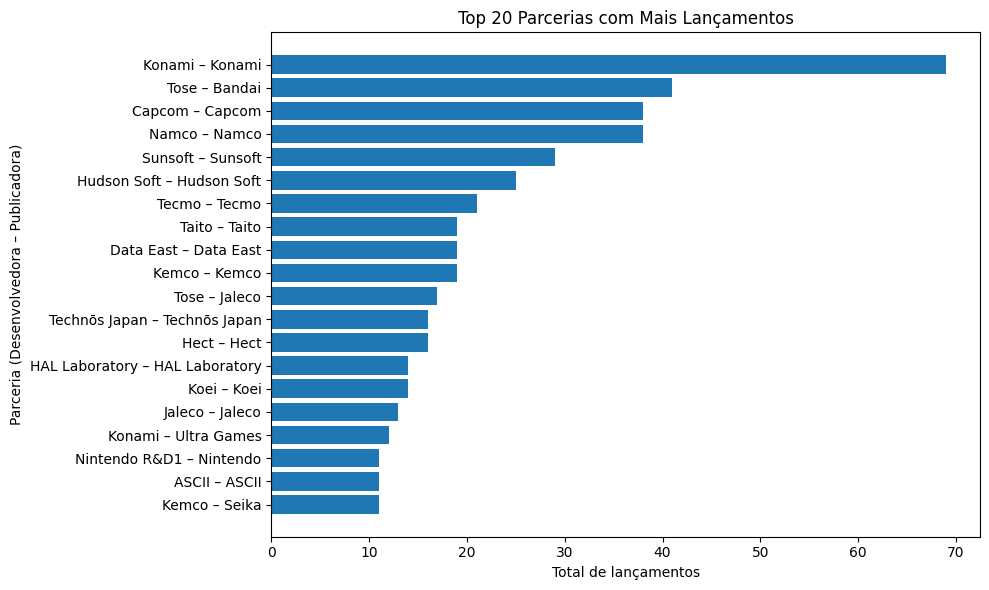

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, concat_ws
# --- Preparação dos dados ---
# Combina os nomes
df_top = (
    resultado
        .withColumn("parceria", 
                    concat_ws(" – ", col("Desenvolvedora"), col("Publicadora")))
        .orderBy(col("total_lancamentos").desc())
        .limit(20)
)

# Converte para Pandas
pdf_top = df_top.toPandas()

# --- Gráfico ---
plt.figure(figsize=(10, 6))

plt.barh(pdf_top["parceria"], pdf_top["total_lancamentos"])
plt.xlabel("Total de lançamentos")
plt.ylabel("Parceria (Desenvolvedora – Publicadora)")
plt.title("Top 20 Parcerias com Mais Lançamentos")
plt.gca().invert_yaxis()  # Deixa o maior no topo

plt.tight_layout()
plt.show()


O gráfico das parcerias mostra que era extremamente comum (16 das 20 principais empresas) que uma mesma empresa desenvolva e publique seus próprios jogos. Isso indica que a grande maioria das empresas da época tinha estrutura própria para lançar seus títulos e preferia controlar todos os processos internamente.

Mesmo assim, o gráfico também destaca alguns casos interessantes de colaboração entre empresas diferentes. A desenvolvedora Tose, por exemplo, aparece duas vezes: uma parceria com Bandai e outra com Jaleco. Isso acontece porque a Tose não tinha uma publicadora própria e, historicamente, trabalhou como uma desenvolvedora “fantasma”, produzindo jogos para outras empresas sem usar seu nome como marca de publicação. Por isso, ela dependia diretamente de publicadoras parceiras para lançar seus títulos.

A Konami também se destaca por aparecer de duas maneiras diferentes: como self-publisher em Konami e Konami, e também na parceria Konami e Ultra Games. Isso se explica pelo fato de que a Konami criou a Ultra Games nos EUA para contornar limitações impostas pela Nintendo, que restringia o número de jogos que uma empresa podia publicar por ano no NES. Assim, a Ultra funcionava como uma “segunda marca” da Konami, permitindo que ela lançasse mais títulos no mercado americano sem violar as regras da época.

Esses casos mostram que, além das parcerias internas, algumas combinações refletem estratégias específicas das empresas, seja por necessidade, como no caso da Tose, ou por decisões comerciais e regulatórias, como no caso da Konami com a Ultra Games.

fonte: https://en.wikipedia.org/wiki/Ultra_Games?utm_source=chatgpt.com

## Felipe Pregnolatto Melo 
Ver todos os desenvolvedores que lançaram um jogo somente em uma região entre um certo intervalo de tempo.

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Desenvolvedora
Arc System Works Capcom
Bit Managers
Chris Gray Enterprises
Cirque Verte
David Braben Ian Bell
ITL OLM
KAZe
LucasArts Realtime Associates
Nintendo EAD
Nintendo R&D1 HAL Laboratory


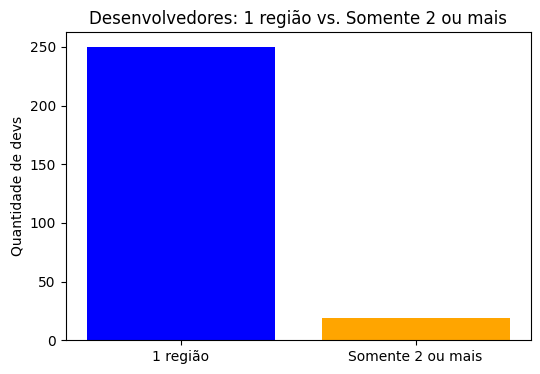

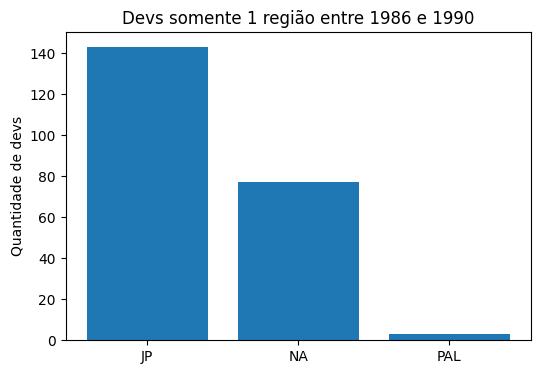

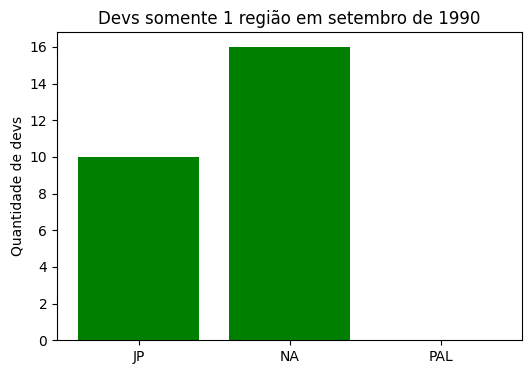

In [0]:
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt

#1. Desenvolvedoras que lançaram pelo menos 1 jogo em somente 1 região vs desenvolvedoras que somente lançaram em multi regiões


query_one_region = """
SELECT DISTINCT d.pk_dev
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
WHERE 
    (jf.pk_data_JP != -1 AND jf.pk_data_NA = -1 AND jf.pk_data_PAL = -1)
 OR (jf.pk_data_JP = -1 AND jf.pk_data_NA != -1 AND jf.pk_data_PAL = -1)
 OR (jf.pk_data_JP = -1 AND jf.pk_data_NA = -1 AND jf.pk_data_PAL != -1)
"""
devs_uma_regiao = spark.sql(query_one_region)

#Seleciona todos os desenvolvedores para tirar os que lançaram em uma região
all_devs = dimDesenvolvedoras.select("pk_dev").distinct()
devs_multi_region = all_devs.subtract(devs_uma_regiao)


#Já que provavelmente são poucos, é interesante ver quais eles são
devs_multi_region_names = (
    devs_multi_region
    .join(dimDesenvolvedoras, on="pk_dev", how="left")
    .select("Desenvolvedora")
)
display(devs_multi_region_names)


#Pegue o número para mostrar na tabeça
count_one_region = devs_uma_regiao.count()
count_multi_region = devs_multi_region.count()

plt.figure(figsize=(6,4))
plt.bar(["1 região", "Somente 2 ou mais"], [count_one_region, count_multi_region], color=["blue", "orange"])
plt.ylabel("Quantidade de devs")
plt.title("Desenvolvedores: 1 região vs. Somente 2 ou mais")
plt.show()

#2.Comparar quantidade de desenvolvedores que lançaram 1 jogo somente em cada região entre 1986 e 1990

#So jp
query_only_jp = """
SELECT DISTINCT d.Desenvolvedora
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
JOIN DimData dd_jp ON jf.pk_data_JP = dd_jp.pk_data
LEFT JOIN DimData dd_na ON jf.pk_data_NA = dd_na.pk_data
LEFT JOIN DimData dd_pal ON jf.pk_data_PAL = dd_pal.pk_data
WHERE 
    dd_jp.ano BETWEEN 1986 AND 1990
    AND dd_na.ano = -1
    AND dd_pal.ano = -1
"""
devs_only_jp = spark.sql(query_only_jp)

#na
query_only_na = """
SELECT DISTINCT d.Desenvolvedora
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
JOIN DimData dd_jp ON jf.pk_data_JP = dd_jp.pk_data
LEFT JOIN DimData dd_na ON jf.pk_data_NA = dd_na.pk_data
LEFT JOIN DimData dd_pal ON jf.pk_data_PAL = dd_pal.pk_data
WHERE 
    dd_jp.ano = -1
    AND dd_na.ano BETWEEN 1986 AND 1990
    AND dd_pal.ano = -1
"""
devs_only_na = spark.sql(query_only_na)

#PAL
query_only_pal = """
SELECT DISTINCT d.Desenvolvedora
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
JOIN DimData dd_jp ON jf.pk_data_JP = dd_jp.pk_data
LEFT JOIN DimData dd_na ON jf.pk_data_NA = dd_na.pk_data
LEFT JOIN DimData dd_pal ON jf.pk_data_PAL = dd_pal.pk_data
WHERE 
    dd_jp.ano = -1
    AND dd_na.ano = -1
    AND dd_pal.ano BETWEEN 1986 AND 1990
"""
devs_only_pal = spark.sql(query_only_pal)

plt.figure(figsize=(6,4))
plt.bar(
    ["JP", "NA", "PAL"],
    [devs_only_jp.count(), devs_only_na.count(), devs_only_pal.count()],
)
plt.ylabel("Quantidade de devs")
plt.title("Devs somente 1 região entre 1986 e 1990")
plt.show()



#JP
query_only_jp = """
SELECT DISTINCT d.Desenvolvedora
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
JOIN DimData dd_jp ON jf.pk_data_JP = dd_jp.pk_data
LEFT JOIN DimData dd_na ON jf.pk_data_NA = dd_na.pk_data
LEFT JOIN DimData dd_pal ON jf.pk_data_PAL = dd_pal.pk_data
WHERE 
    dd_jp.ano = 1990 AND dd_jp.mes_num = 9
    AND dd_na.ano = -1
    AND dd_pal.ano = -1
"""
devs_only_jp = spark.sql(query_only_jp)

#na
query_only_na = """
SELECT DISTINCT d.Desenvolvedora
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
JOIN DimData dd_jp ON jf.pk_data_JP = dd_jp.pk_data
LEFT JOIN DimData dd_na ON jf.pk_data_NA = dd_na.pk_data
LEFT JOIN DimData dd_pal ON jf.pk_data_PAL = dd_pal.pk_data
WHERE 
    dd_jp.ano = -1
    AND dd_na.ano = 1990 AND dd_na.mes_num = 9
    AND dd_pal.ano = -1
"""
devs_only_na = spark.sql(query_only_na)

#PAL
query_only_pal = """
SELECT DISTINCT d.Desenvolvedora
FROM JogoFato jf
JOIN DimDesenvolvedoras d ON jf.pk_dev = d.pk_dev
JOIN DimData dd_jp ON jf.pk_data_JP = dd_jp.pk_data
LEFT JOIN DimData dd_na ON jf.pk_data_NA = dd_na.pk_data
LEFT JOIN DimData dd_pal ON jf.pk_data_PAL = dd_pal.pk_data
WHERE 
    dd_jp.ano = -1
    AND dd_na.ano = -1
    AND dd_pal.ano = 1990 AND dd_pal.mes_num = 9
"""
devs_only_pal = spark.sql(query_only_pal)

plt.figure(figsize=(6,4))
plt.bar(
    ["JP", "NA", "PAL"],
    [devs_only_jp.count(), devs_only_na.count(), devs_only_pal.count()],
    color = ["green"]
)
plt.ylabel("Quantidade de devs")
plt.title("Devs somente 1 região em setembro de 1990")
plt.show()



Gráfico 1

É possível ver a grande diferença, onde a maioria das desenvolvedoras fez um jogo para somente 1 região, mas ainda existem algumas desenvolvedoras que lançaram para várias regiões, que são grandes desenvolvedoras como Arcsys Campcom e filiais da Nintendo.

Grafico 2

Neste grande intervalo de tempo, é possível ver como a grande maioria das desenvolvedoras lançou jogos somente para o japão e como quase nenhuma lançou para o PAL

Grafico 3

Agora pegando um intervalo de tempo bem especifico e curto, é possível ver que algumas desenvolvedoras lançaram mais jogos para o NA do que para o japão em alguns momentos da vida do NES

# Conclusões 

 Este projeto nos mostrou na pratica um exemplo do processo de extrair e transformar dados de uma fonte qualquer.
 Vimos como pode ser difícil esse processo, conosco já tendo muita dificuldade em conseguir transformar os dados de uma maneira correta, sendo que a fonte deles já veio com eles bem padronizados, mas foi uma boa experiência, nos mostrando como um data lakehouse se comporta e como ele é bem fácil de se consultar quando é bem estruturado e como nosso projeto pode crescer com outras fontes de dados, por exemplo de jogos de outros consoles.

# Contribuições dos integrantes do grupo

 - Anne: Fez completamente a extração da fonte de dados e criação da camada bronze, assim como a adição do calculo da métrica da tabela fato, o campo de data_string e a formatação deste documento. Foi a responsável pela própia consulta.

 - Felipe: Fez a padronização das datas na camadada prata e criação das dimensões e da tabela fato na camada ouro. Reponsável por escrever a conclusão, criar o fluxograma e pela própria consulta.